In [1]:
import xarray as xr
import glob
import os
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
from scipy import interpolate
import gsw
date_1 = datetime.datetime.strptime('01/01/1950', "%m/%d/%Y")

#LOAD IPRC AND MIT FIRST BECAUSE THEY'RE NOT ARRANGED PER MONTHLY FILE...
#
#LOAD IPRC
#path = '/home1/ballycotton/DATA/IPRC/'
#allFiles = glob.glob(path + "*.dat")
#allFiles.sort()
#cnames=['Lon','Lat','Level','Depth','JULD','TEMP','PSAL','POTM','PSIG','ERRT','ERRS','WMO','CYCLE']
#colm=[0,1,2,3,4,5,6,7,8,12,13,20,21]
#td_=[]
#for file_ in allFiles:
#    #print file_
#    df = pd.read_csv(file_,delim_whitespace=True,index_col=None, header=None, usecols=colm, names=cnames)    
#    df['JULD']=df['JULD']+18262
#    df=df[((df['Lat']>20) & (df['Lat']<45) & (df['Lon']>-85) & (df['Lon']<-35))]
#    td_.append(df)
#IPframe=pd.concat(td_,sort=False)

#MIT LOAD
MIP = '/home1/ballycotton/DATA/MIT-SDL/'
path = glob.glob(os.path.join(MIP+'*.nc'))
path.sort()
MIT=xr.open_mfdataset(path,decode_times=False,mask_and_scale=True)
# JULD MIT
MIT=MIT.assign(prof_juld = MIT.prof_date - 712224)
#GEOSUBSET MIT
MIT=MIT.where((MIT.prof_lat>20) & (MIT.prof_lat<45) & (MIT.prof_lon>-85) & (MIT.prof_lon<-30),drop=True)

In [2]:
#YEAR MONTH TO PROCESS
#####################
yeart='2006'
montht='01'
#####################

#OCCIPUT LOAD
OCCI = '/home1/ballycotton/DATA/PIRATE/SDL_INTERP/'+yeart+'/'
path = glob.glob(os.path.join(OCCI+'*'+montht+'.nc'))
#OPEN
OCC=xr.open_dataset(path[0],decode_times=False,mask_and_scale=True)
#REMOVE FIRST LEVEL (0m)
OCC=OCC.where(OCC.STANDARD_LEVELS<0,drop=True)
# ALIGN VARIABLES ALONG ONE DIMENSION 
OCC['A']=OCC.JULD.min(dim='N_LEVELS')
OCC['B']=OCC.STATION_IDENTIFIER.min(dim='N_LEVELS')
OCC['C']=OCC.LATITUDE.min(dim='N_LEVELS')
OCC['D']=OCC.LONGITUDE.min(dim='N_LEVELS')
OCC['E']=OCC.CYCLE_NUMBER.min(dim='N_LEVELS')
OCC=OCC.drop(['JULD','STATION_IDENTIFIER','LATITUDE','LONGITUDE','CYCLE_NUMBER'])
OCC=OCC.rename({'A':'JULD','B':'STATION_IDENTIFIER','C':'LATITUDE','D':'LONGITUDE','E':'CYCLE_NUMBER'})

#INIT FINAL DATASET
OCF= xr.Dataset({'STANDARD_LEVELS': (['N_LEVELS'],  OCC.STANDARD_LEVELS),
                'JULD': (['N_OBS'], OCC.JULD),
                'CYCLE_NUMBER': (['N_OBS'], OCC.CYCLE_NUMBER), 
                'LONGITUDE': (['N_OBS'], OCC.LONGITUDE),
                'LATITUDE': (['N_OBS'], OCC.LATITUDE),
                'STATION_IDENTIFIER': (['N_OBS'], OCC.STATION_IDENTIFIER), 
                'TEMP_OBS': (['N_OBS','N_LEVELS'], OCC.TEMP_OBS),
                'PSAL_OBS': (['N_OBS','N_LEVELS'], OCC.PSAL_OBS),
                'POTM_OBS': (['N_OBS','N_LEVELS'], OCC.POTM_OBS), 
                'POTM_Hx': (['N_MEMBER','N_OBS','N_LEVELS'], OCC.POTM_Hx), 
                'PSAL_Hx': (['N_MEMBER','N_OBS','N_LEVELS'], OCC.PSAL_Hx), 
                'POTM_OTH': (['N_DATASET','N_OBS','N_LEVELS'], np.zeros([2,len(OCC.N_OBS),299])),                
                'PSAL_OTH': (['N_DATASET','N_OBS','N_LEVELS'], np.zeros([2,len(OCC.N_OBS),299])),                 
                #'DATASETS': (['N_DATASET'], ['ISAS15','IPRC','MIT'])                
                 'DATASETS': (['N_DATASET'], ['ISAS15','MIT-ECCO'])                
                })
OCC = OCF
print OCC

<xarray.Dataset>
Dimensions:             (N_DATASET: 2, N_LEVELS: 299, N_MEMBER: 50, N_OBS: 92)
Dimensions without coordinates: N_DATASET, N_LEVELS, N_MEMBER, N_OBS
Data variables:
    STANDARD_LEVELS     (N_LEVELS) float64 -5.0 -10.0 -15.0 -20.0 -25.0 ...
    POTM_Hx             (N_MEMBER, N_OBS, N_LEVELS) float64 16.86 16.86 ...
    JULD                (N_OBS) float64 2.045e+04 2.045e+04 2.045e+04 ...
    LONGITUDE           (N_OBS) float64 -62.0 -52.28 -52.26 -58.65 -62.44 ...
    TEMP_OBS            (N_OBS, N_LEVELS) float64 17.92 17.92 17.91 17.91 ...
    PSAL_OTH            (N_DATASET, N_OBS, N_LEVELS) float64 0.0 0.0 0.0 0.0 ...
    STATION_IDENTIFIER  (N_OBS) object '4900525 ' '4900352 ' '4900352 ' ...
    CYCLE_NUMBER        (N_OBS) float64 43.0 83.0 83.0 61.0 7.0 10.0 57.0 ...
    DATASETS            (N_DATASET) |S8 'ISAS15' 'MIT-ECCO'
    POTM_OBS            (N_OBS, N_LEVELS) float64 17.92 17.92 17.91 17.9 ...
    PSAL_OBS            (N_OBS, N_LEVELS) float64 35.9 35.9 35.9 

In [3]:
##########
#  ISAS  #
##########
#LOAD
ISAS = '/home/lpo4/ISAS_LPO/ANA_ISAS15_ARGO/data/'+yeart+'/'
path = glob.glob(os.path.join(ISAS+'*'+yeart+montht+'15_dat_*.nc'))
ISA_S=xr.open_dataset(path[0],decode_times=False,mask_and_scale=True)
ISA_T=xr.open_dataset(path[1],decode_times=False,mask_and_scale=True)
#GEOSUBSET
ISA_T=ISA_T.where((ISA_T.LATITUDE>20) & (ISA_T.LATITUDE<45) & (ISA_T.LONGITUDE>-85) & (ISA_T.LONGITUDE<-30),drop=True)
ISA_S=ISA_S.where((ISA_S.LATITUDE>20) & (ISA_S.LATITUDE<45) & (ISA_S.LONGITUDE>-85) & (ISA_S.LONGITUDE<-30),drop=True)
#MATCHING LOOKUP ARRAY
IST= xr.Dataset({'PLATFORM_NUMBER': (['JULD'],  ISA_T.PLATFORM_NUMBER),
                'LATITUDE': (['JULD'], ISA_T.LATITUDE),
                'LONGITUDE': (['JULD'], ISA_T.LONGITUDE),
                'TEMP': (['JULD','N_LEVELS'], ISA_T.TEMP-ISA_T.TEMP_RESI),                
                'DEPH': (['N_LEVELS','JULD'], ISA_T.DEPH),                
                },
                 coords={'JULD': ISA_T.JULD.values})
ISS= xr.Dataset({'PLATFORM_NUMBER': (['JULD'],  ISA_S.PLATFORM_NUMBER),
                'LATITUDE': (['JULD'], ISA_S.LATITUDE),
                'LONGITUDE': (['JULD'], ISA_S.LONGITUDE),
                'PSAL': (['JULD','N_LEVELS'], ISA_S.PSAL-ISA_S.PSAL_RESI),                
                'DEPH': (['N_LEVELS','JULD'], ISA_S.DEPH),                
                },
                 coords={'JULD': ISA_S.JULD.values})
 
#FIND ARRAY
OCC['FIND']= xr.DataArray(np.zeros(len(OCC.N_OBS))+1,dims= {'N_OBS'})
#GO MATCH AND INTERP
for i in OCC.N_OBS.values :
    A1t=IST.where(IST.PLATFORM_NUMBER.isin([OCC.STATION_IDENTIFIER[i].values]),drop=True)    
    A1s=ISS.where(ISS.PLATFORM_NUMBER.isin([OCC.STATION_IDENTIFIER[i].values]),drop=True) 
    A1t=A1t.sortby(A1t.JULD)
    A1s=A1s.sortby(A1s.JULD)
    if (len(A1s.JULD)>0):             
        A2t=A1t.sel(JULD=[OCC.JULD[i].values],method='nearest')
        A2s=A1s.sel(JULD=[OCC.JULD[i].values],method='nearest')
        
        #POTENTIAL TEMPERATURE CALCULATION        
        PRES=gsw.p_from_z(-A2t.DEPH[:,0].values,A2t.LATITUDE[0].values)
        SA=gsw.SA_from_SP(A2s.PSAL[0,:], PRES, A2t.LONGITUDE[0], A2t.LATITUDE[0])
        POTM=gsw.pt0_from_t(SA,A2t.TEMP[0,:].values,PRES)          
        
        if(abs(A2t.JULD.values-OCC.JULD[i].values)<0.1):
            #INTERPOLATE ISAS PROFILE ON SDT LEVEL            
            tok1=~np.isnan(POTM)
            tok2=~np.isnan(A2s.PSAL[0,:])
            ft = interpolate.interp1d(A2t.DEPH[tok1,0], POTM[tok1], kind='linear',bounds_error=False, fill_value=np.nan)
            fs = interpolate.interp1d(A2s.DEPH[tok2,0], A2s.PSAL[0,tok2], kind='linear',bounds_error=False, fill_value=np.nan)
            OCC.POTM_OTH[0,i,:] = ft(-OCC.STANDARD_LEVELS.values)
            OCC.PSAL_OTH[0,i,:] = fs(-OCC.STANDARD_LEVELS.values)
        else:
            OCC.FIND[i]=0        
    else:
        OCC.FIND[i]=0        
OCC=OCC.where(OCC.FIND==1,drop=True)        
OCC['STANDARD_LEVELS'] = OCC['STANDARD_LEVELS'].isel(N_OBS=0)
OCC=OCC.drop('FIND')

/opt/anaconda2/lib/python2.7/site-packages/gsw/gibbs/conversions.py:63: RuntimeWarning: invalid value encountered in greater
  cond1 = ((p < 100) & (SP > 120))
/opt/anaconda2/lib/python2.7/site-packages/gsw/gibbs/conversions.py:64: RuntimeWarning: invalid value encountered in greater
  cond2 = ((p >= 100) & (SP > 42))
/opt/anaconda2/lib/python2.7/site-packages/gsw/utilities/utilities.py:285: RuntimeWarning: invalid value encountered in less
  SA[SA < 0] = np.ma.masked


In [ ]:
##########
#  IPRC  #
##########
#FIND ARRAY
#OCC['FIND']= xr.DataArray(np.zeros(len(OCC.N_OBS))+1,dims= {'N_OBS'})
#GO FOR IPRC
#for i in OCC.N_OBS.values:
#    A1=IPframe[IPframe['WMO']==int(OCC.STATION_IDENTIFIER[i].values)]    
#    if(len(A1)>0):
#        A2=A1[abs(A1['JULD'] - OCC.JULD[i].values)<0.1]
#        if(len(A2)>2) :
#            if (min(A2['Depth'])<=5) & (max(A2['Depth'])>=1500) :
#                #INTERPOLATE HERE
#                ft = interpolate.interp1d(A2['Depth'], A2['POTM']-A2['ERRT'])
#                fs = interpolate.interp1d(A2['Depth'], A2['PSAL']-A2['ERRS'])
#                OCC.TEMP_OTH[1,i,:] = ft(-OCC.STANDARD_LEVELS.values)
#                OCC.PSAL_OTH[1,i,:] = fs(-OCC.STANDARD_LEVELS.values)   
#            else:
#                OCC.FIND[i]=0    
#        else:
#            OCC.FIND[i]=0    
#    else:
#        OCC.FIND[i]=0
#OCC=OCC.where(OCC.FIND==1,drop=True)        
#OCC['STANDARD_LEVELS'] = OCC['STANDARD_LEVELS'].isel(N_OBS=0)
#OCC=OCC.drop('FIND')        

In [4]:
##########
#   MIT  #
##########
#MATCHING LOOKUP ARRAY
MITS= xr.Dataset({'PLATFORM_NUMBER': (['JULD'],  MIT.prof_descr.astype('int')),
                'LATITUDE': (['JULD'], MIT.prof_lat),
                'LONGITUDE': (['JULD'], MIT.prof_lon),
                'TEMP': (['JULD','N_LEVELS'], MIT.prof_TeccoV4R2),
                'PSAL': (['JULD','N_LEVELS'], MIT.prof_SeccoV4R2),      
                'DEPH': (['JULD','N_LEVELS'], MIT.prof_depth),                
                },
                 coords={'JULD': MIT.prof_juld.values})
#FIND ARRAY
OCC['FIND']= xr.DataArray(np.zeros(len(OCC.N_OBS))+1,dims= {'N_OBS'})
#GO FOR MIT
for i in OCC.N_OBS.values :
    A1=MITS.where(MITS.PLATFORM_NUMBER.isin([int(OCC.STATION_IDENTIFIER[i].values)]),drop=True)        
    A1=A1.sortby(A1.JULD)
    if (len(A1.JULD)>0):             
        A2=A1.sel(JULD=[OCC.JULD[i].values],method='nearest')        
        if(abs(A2.JULD.values-OCC.JULD[i].values)<0.1):
            #INTERPOLATE ISAS PROFILE ON SDT LEVEL            
            ft = interpolate.interp1d(A2.DEPH[0,:], A2.TEMP[0,:])
            fs = interpolate.interp1d(A2.DEPH[0,:], A2.PSAL[0,:])
            OCC.POTM_OTH[1,i,:] = ft(-OCC.STANDARD_LEVELS.values)
            OCC.PSAL_OTH[1,i,:] = fs(-OCC.STANDARD_LEVELS.values)           
        else:
            OCC.FIND[i]=0  
    else:
        OCC.FIND[i]=0        
OCC=OCC.where(OCC.FIND==1,drop=True)        
OCC['STANDARD_LEVELS'] = OCC['STANDARD_LEVELS'].isel(N_OBS=0)
OCC=OCC.drop('FIND')
OCC['DATASETS'] = OCC['DATASETS'].isel(N_OBS=0)
print OCC


<xarray.Dataset>
Dimensions:             (N_DATASET: 2, N_LEVELS: 299, N_MEMBER: 50, N_OBS: 86)
Dimensions without coordinates: N_DATASET, N_LEVELS, N_MEMBER, N_OBS
Data variables:
    STANDARD_LEVELS     (N_LEVELS) float64 -5.0 -10.0 -15.0 -20.0 -25.0 ...
    POTM_Hx             (N_MEMBER, N_OBS, N_LEVELS) float64 16.86 16.86 ...
    JULD                (N_OBS) float64 2.045e+04 2.045e+04 2.045e+04 ...
    LONGITUDE           (N_OBS) float64 -62.0 -52.28 -52.26 -58.65 -62.44 ...
    TEMP_OBS            (N_OBS, N_LEVELS) float64 17.92 17.92 17.91 17.91 ...
    PSAL_OTH            (N_DATASET, N_OBS, N_LEVELS) float64 35.7 35.71 ...
    STATION_IDENTIFIER  (N_OBS) object '4900525 ' '4900352 ' '4900352 ' ...
    CYCLE_NUMBER        (N_OBS) float64 43.0 83.0 83.0 61.0 7.0 10.0 57.0 ...
    DATASETS            (N_DATASET) object 'ISAS15' 'MIT-ECCO'
    POTM_OBS            (N_OBS, N_LEVELS) float64 17.92 17.92 17.91 17.9 ...
    PSAL_OBS            (N_OBS, N_LEVELS) float64 35.9 35.9 35.9 35

In [ ]:
#OCC.to_netcdf('/home1/ballycotton/DATA/PIRATE/SDL_DATASETS/'+yeart+montht+'_test.nc')

<IPython.core.display.Javascript object>


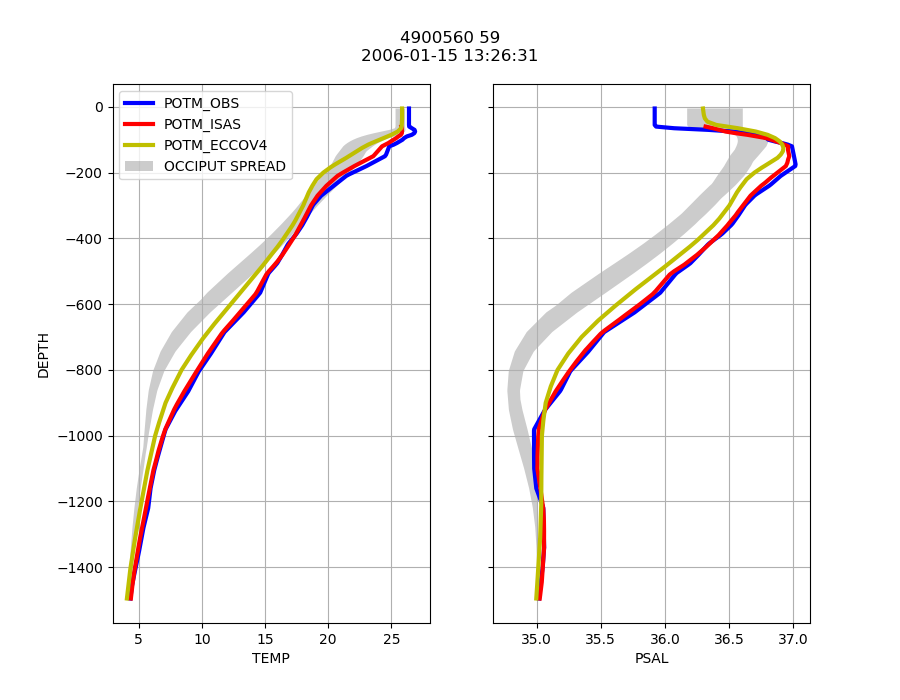

Text(0.5,0,u'PSAL')

In [14]:
%matplotlib notebook
indx=39
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=[9,7])
f.suptitle('\n'+str(OCC.STATION_IDENTIFIER[indx].values)+str(int(OCC.CYCLE_NUMBER[indx].values))+'\n'+
           str(date_1 + datetime.timedelta(days=float(OCC.JULD[indx].values))))
ax1.grid(True)
ax2.grid(True)
l1,=ax1.plot(OCC.POTM_OBS[indx,:],OCC.STANDARD_LEVELS,'b-',linewidth=3.0,label='POTM_OBS')
l2,=ax1.plot(OCC.POTM_OTH[0,indx,:],OCC.STANDARD_LEVELS,'r-',linewidth=3.0,label='POTM_ISAS')
#l3,=ax1.plot(OCC.POTM_OTH[1,indx,:],OCC.STANDARD_LEVELS,'g-',linewidth=3.0,label='POTM_IPRC')
l4,=ax1.plot(OCC.POTM_OTH[1,indx,:],OCC.STANDARD_LEVELS,'y-',linewidth=3.0,label='POTM_ECCOV4')
l5=ax1.fill_betweenx(OCC.STANDARD_LEVELS,
                  OCC.POTM_Hx[:,indx,:].min('N_MEMBER'),
                  OCC.POTM_Hx[:,indx,:].max('N_MEMBER'),
                  facecolor='gray', alpha=0.4, label='OCCIPUT SPREAD')
ax1.legend(handles=[l1, l2, l4, l5])
ax1.set_xlabel('TEMP')
ax1.set_ylabel('DEPTH')

ax2.plot(OCC.PSAL_OBS[indx,:],OCC.STANDARD_LEVELS,'b-',linewidth=3.0)
ax2.plot(OCC.PSAL_OTH[0,indx,:],OCC.STANDARD_LEVELS,'r-',linewidth=3.0)
#ax2.plot(OCC.PSAL_OTH[1,indx,:],OCC.STANDARD_LEVELS,'g-',linewidth=3.0)
ax2.plot(OCC.PSAL_OTH[1,indx,:],OCC.STANDARD_LEVELS,'y-',linewidth=3.0)
ax2.fill_betweenx(OCC.STANDARD_LEVELS,
                  OCC.PSAL_Hx[:,indx,:].min('N_MEMBER'),
                  OCC.PSAL_Hx[:,indx,:].max('N_MEMBER'),
                  facecolor='gray', alpha=0.4, label='OCCIPUT SPREAD')
ax2.set_xlabel('PSAL')


4900595  ['4900595 ']
[0.]


<IPython.core.display.Javascript object>


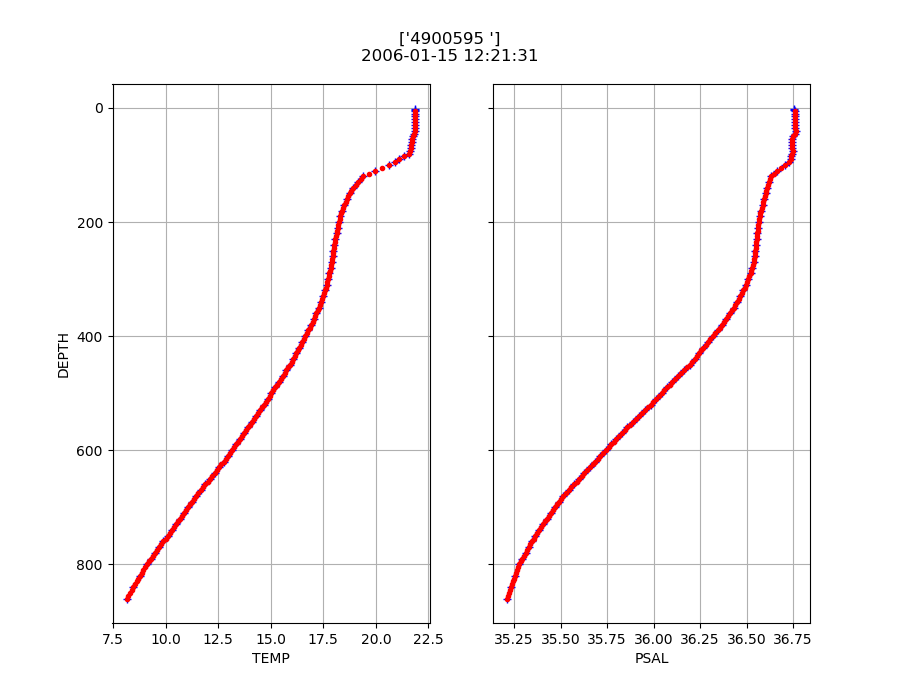

Text(0.5,0,u'PSAL')

In [8]:
iz=38
AT=IST.where(IST.PLATFORM_NUMBER.isin([OCC.STATION_IDENTIFIER[iz].values]),drop=True)
AS=ISS.where(ISS.PLATFORM_NUMBER.isin([OCC.STATION_IDENTIFIER[iz].values]),drop=True)
AT=AT.sortby(AT.JULD)
AS=AS.sortby(AS.JULD)
BT=AT.sel(JULD=[OCC.JULD[iz].values],method='nearest')  
BS=AS.sel(JULD=[OCC.JULD[iz].values],method='nearest')  
print OCC.STATION_IDENTIFIER[iz].values,BT.PLATFORM_NUMBER.values
print abs(BT.JULD.values-OCC.JULD[iz].values)

#POTENTIAL TEMPERATURE CALCULATION
PRES=gsw.p_from_z(-BT.DEPH[:,0].values,BT.LATITUDE[0].values)
SA=gsw.SA_from_SP(BS.PSAL[0,:], PRES, BT.LONGITUDE[0], BT.LATITUDE[0])
POTM=gsw.pt0_from_t(SA,BT.TEMP[0,:].values,PRES)  

#INTERP     
tok1=~np.isnan(POTM)
tok2=~np.isnan(BS.PSAL[0,:])
ft = interpolate.interp1d(BT.DEPH[tok1,0], POTM[tok1], kind='linear',bounds_error=False, fill_value=np.nan)
fs = interpolate.interp1d(BS.DEPH[tok2,0], BS.PSAL[0,tok2], kind='linear',bounds_error=False, fill_value=np.nan)
POTMi = ft(-OCC.STANDARD_LEVELS.values)
PSALi = fs(-OCC.STANDARD_LEVELS.values)    

%matplotlib notebook
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=[9,7])
f.suptitle('\n'+str(BT.PLATFORM_NUMBER.values)+'\n'+
           str(date_1 + datetime.timedelta(days=float(BT.JULD.values))))
ax1.grid(True)
ax1.invert_yaxis()
ax2.grid(True)
ax1.plot(POTM,BT.DEPH[:,0],'b+',linewidth=3.0)
ax1.plot(POTMi,-OCC.STANDARD_LEVELS,'r.',linewidth=3.0)
ax1.set_xlabel('TEMP')
ax1.set_ylabel('DEPTH')
ax2.plot(BS.PSAL[0,:],BS.DEPH[:,0],'b+',linewidth=3.0)
ax2.plot(PSALi,-OCC.STANDARD_LEVELS,'r.',linewidth=3.0)
ax2.set_xlabel('PSAL')
